## 5 - Базовая модель

### 5.1 - Библиотеки

In [1]:
import pandas as pd
import numpy as np

import yaml
import io

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from scipy.stats import spearmanr


import statsmodels.api as sm
import statsmodels.formula.api as smf

import _utils.feature_selection_tests as fst
from _utils.model_test_functions import get_coef, roc
from _utils.text_preporation import master_scale


from _utils.ExcelExporter import ExcelExporter
from _utils.Style import Style

import warnings
warnings.filterwarnings("ignore")

### 5.2 - Пути

In [2]:
with open('../CONFIGS.yaml', 'r', encoding='utf-8') as file:
    CONFIG = yaml.safe_load(file)

PATHS = CONFIG['data_paths']

In [3]:
filepath = {
      'clean_data'         : PATHS['other']['clean_data']
    , 'qualitative_preds'  : PATHS['module_qualitative']['predictions']
    , 'quantitative_preds' : PATHS['module_quantitative']['predictions']
    , 'rating_weights'     : PATHS['ratings']['weights']
    , 'config'             : PATHS['other']['this_config']
    , 'predictions'        : PATHS['model_base']['predictions']
    , 'excel'              : PATHS['model_base']['excel']
    , 'master_scale'       : PATHS['ratings']['master_scale']
}

TTC = CONFIG['calibration_params']['central_tendency']['TTC']
PIT = CONFIG['calibration_params']['central_tendency']['PIT']

In [4]:
target_col = 'target'
weight_col = 'W_norm'
id_columns = ['client_id', 'rating_id', target_col, weight_col]

selected_features = ['quantitative_logits', 'qualitative_logits']

vif_upper_bound = 5

### 5.3 - Данные

In [5]:
df_main       = pd.read_parquet(filepath['clean_data'])
df_quant_pred = pd.read_parquet(filepath['quantitative_preds'])
df_qual_pred  = pd.read_parquet(filepath['qualitative_preds'])
df_weight     = pd.read_parquet(filepath['rating_weights'])

master = pd.read_excel(filepath['master_scale'])
master.rename(columns = { 'Рейтинг':'rating'
                        , 'Нижний предел':'lower_bound'
                        , 'Вероятность Дефолта': 'pd'
                        , 'Верхний предел':'upper_bound' }, inplace=True)

In [6]:
with open(filepath['config']) as stream:
    config = yaml.load(stream, Loader=yaml.Loader)

In [7]:
df_weight = df_weight[['rating_id', weight_col]]

### 5.4 - Обработка данных

In [8]:
data = pd.merge(df_main,
                df_weight,
                how='inner',
                on=['rating_id'])


data = pd.merge(data,
                df_quant_pred,
                how='left',
                on=['rating_id'])


data = pd.merge(data,
                df_qual_pred,
                how='left',
                on=['rating_id'])

data['rating_assignment_date'] = pd.to_datetime(data['rating_assignment_date'])
# data['TS_quant'] = np.log(1 / (data['quantitative_preds']) - 1) * -1
# data['TS_qual'] = np.log(1 / (data['qualitative_preds']) - 1) * -1
data['quantitative_logits'] = np.log(1 / (data['quantitative_preds']) - 1) * -1
data['qualitative_logits'] = np.log(1 / (data['qualitative_preds']) - 1) * -1
print(data.shape)
data.head()

(4984, 17)


,bin,client_id,rating_id,rating_preliminary,rating_final,rating_assignment_date,target,survive,in_portfolio,segment_first_entry_date_when_healthy,is_segment,drop_date,W_norm,quantitative_preds,qualitative_preds,quantitative_logits,qualitative_logits
0,100740010845,176783,1737,19,19.0,2018-12-12,0,1,1,2018-02-01,1,2018-12-12,2.843321,0.093473,0.037188,-2.271949,-3.253874
1,31040000999,197185,1048,23,23.0,2018-08-14,0,1,1,2018-02-01,1,2018-08-14,2.365725,0.116082,0.090401,-2.030063,-2.308750
2,80740006642,197255,912,25,25.0,2018-07-30,0,1,1,2018-07-01,1,2018-07-30,1.014112,0.124282,0.149195,-1.952490,-1.740931
3,80740006642,197255,1734,24,24.0,2018-12-19,0,1,1,2018-07-01,1,2018-12-19,0.767105,0.124282,0.149195,-1.952490,-1.740931
4,80740006642,197255,2254,24,24.0,2019-04-08,0,1,1,2018-07-01,1,2019-04-08,1.239054,0.054492,0.149195,-2.853659,-1.740931


In [9]:
data[['quantitative_logits', 'qualitative_logits', weight_col]].corr()

,quantitative_logits,qualitative_logits,W_norm
quantitative_logits,1.000000,0.254958,-0.009241
qualitative_logits,0.254958,1.000000,-0.030602
W_norm,-0.009241,-0.030602,1.000000


In [10]:
data.dropna(subset=['quantitative_logits', 'qualitative_logits', weight_col, target_col], inplace=True)

### 5.5 - Построение модели

In [11]:
x = data[['quantitative_logits', 'qualitative_logits', weight_col]]
y = data[target_col]
sample = x[weight_col]

x.drop([weight_col],axis = 1,inplace=True)

clf = LogisticRegression(  penalty='l2'
                         , solver='liblinear'
                         , fit_intercept=True
                         , random_state=42)
clf.fit(x, y, sample)

LogisticRegression(random_state=42, solver='liblinear')

In [12]:
y_pred = clf.predict_proba(x)[:,1]

coefs, intercept = get_coef(x, y, 5, clf, sample)
model_intercept = intercept

print('На всей выборке: ', clf.intercept_[0], clf.coef_[0])
print('Средние значения: ', intercept, coefs)

for i, j in zip(coefs, x.columns):
    intercept += i * x[j]
    
y_mean = 1 / (1 + np.exp(-intercept))

gini_mean = roc_auc_score(y, y_score=y_mean) * 2 - 1
gini = roc_auc_score(y, y_score=y_pred) * 2 - 1

print('Gini')
print('На средних коэфицентах: ',gini_mean)
print('На обучающей выборке: ',  gini)

На всей выборке:  1.8495385487942788 [0.88934089 0.80151308]
Средние значения:  1.6407205049805647 [0.75481217 0.82899008]
Gini
На средних коэфицентах:  0.6449587155379704
На обучающей выборке:  0.6449756788505661
 1.8495385487942788 [0.88934089 0.80151308]
Средние значения:  1.6407205049805647 [0.75481217 0.82899008]
Gini
На средних коэфицентах:  0.6449587155379704
На обучающей выборке:  0.6449756788505661


In [13]:
x['actual'] = y
x['pred'] = y_mean

x.groupby(['actual'], as_index=False).agg({'pred': 'mean'})

,actual,pred
0,0,0.049189
1,1,0.190492


In [14]:
# data['TS_pred'] = y_mean
data['base_model_preds'] = y_mean
data['base_model_ratings'] = data['base_model_preds'].apply(lambda x: master_scale(x, master))
data.groupby(['target'], as_index=False).agg({'base_model_preds': 'mean'})

,target,base_model_preds
0,0,0.049189
1,1,0.190492


In [15]:
coef_dict = dict(zip(x.columns, coefs,))
coef_dict['intercept'] = model_intercept

for k, v in coef_dict.items():
    coef_dict[k] = float(v)
    
coef_dict

{'quantitative_logits': 0.7548121696606503,
 'qualitative_logits': 0.8289900781789121,
 'intercept': 1.6407205049805647}

In [16]:
target_rate_actual = (data[target_col] * data[weight_col]).sum() / data[weight_col].sum()
target_rate_predicted = data['base_model_preds'].mean()
print('DR фактический', round(float(target_rate_actual)*100,2))
print('DR предсказанный', round(float(target_rate_predicted)*100,2))

DR фактический 5.5
DR предсказанный 5.62


In [17]:
pit_date_start = '2023-07-01'
pit_date_end   = '2024-07-01'
pit_df = data.query('rating_assignment_date >= @pit_date_start and rating_assignment_date < @pit_date_end')[['quantitative_logits', 'qualitative_logits']]

pit_target_rate = clf.predict_proba(pit_df)[:,1].mean()


print('PIT DR фактический', round(float(PIT)*100, 2))
print('PIT DR предсказанный', round(float(pit_target_rate)*100,2))

PIT DR фактический 5.27
PIT DR предсказанный 6.03


Gini: 0.6449587155379704
-----------------------------------
Результат теста: Зеленый


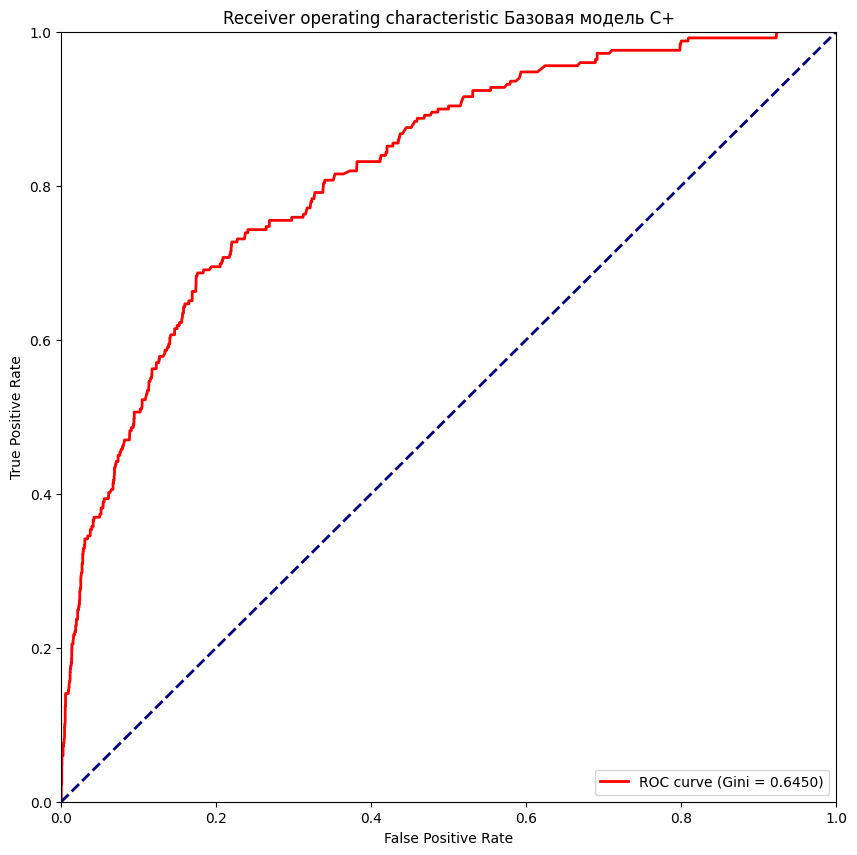

In [18]:
roc(y, y_mean, ' Базовая модель C+')

### 5.6 - Тестирование

#### 5.6.1 - Вклад модулей

In [19]:
dominance_ratio = {'Доля влияния кач. предсказания (%)' : (coef_dict['qualitative_logits'] / (coef_dict['qualitative_logits']+coef_dict['quantitative_logits']))*100 
                   , 'Верхний порог для качественного модуля (%)' : 60 }
dominance_ratio['Прохождение проверки'] = dominance_ratio['Доля влияния кач. предсказания (%)' ] < dominance_ratio['Верхний порог для качественного модуля (%)']
dominance_ratio = pd.DataFrame([dominance_ratio])
dominance_ratio

,Доля влияния кач. предсказания (%),Верхний порог для качественного модуля (%),Прохождение проверки
0,52.341767,60,True


#### 5.6.2 - Стат. тесты

In [20]:
test_results = {}

print('Доминирование')
test_results['dominance'] = dominance_ratio.copy()
dom_pass ='✅ passed' if test_results['dominance']['Прохождение проверки'].all() else '❌ failed'
display(test_results['dominance'])

print('Spearman')
test_results['spearman'] = (data[selected_features]
    .corr(method='spearman')\
    .unstack().reset_index()\
    .query('level_0 != level_1')
    .set_axis(['Признак 1', 'Признак 2', 'Коэфф. Спирмена'], axis=1)
    )
test_results['spearman']['abs() < 0.65'] = test_results['spearman']['Коэфф. Спирмена'].abs() < 0.65
spearman_pass ='✅ passed' if test_results['spearman']['abs() < 0.65'].all() else '❌ failed'
display(test_results['spearman'])

print('Pearson')
person_corr = []
for col1, col2 in combinations(selected_features, 2):
    corr_coef, _ = spearmanr(data[col1], data[col2], nan_policy='omit')
    person_corr.append({
        'feature_1': col1,
        'feature_2': col2,
        'spearman_corr': corr_coef,
        'abs() < 0.7': abs(corr_coef) < 0.7
    })

person_corr = pd.DataFrame(person_corr).set_axis(['Признак 1', 'Признак 2', 'Коэфф. Спирмена', 'abs < 0.7'], axis=1)
pearson_pass = '✅ passed' if person_corr[ 'abs < 0.7'].all() else '❌ failed'
test_results['pearson'] = person_corr
display(test_results['pearson'])

print('Wald')
keep_columns = selected_features + [weight_col, target_col]
string = 'target' + ' ~ '
for i in range(len(keep_columns[:-1])):
    string += keep_columns[i] + '+'
string = string[:-1]
print(string)

fit = smf.glm(string,
              family=sm.families.Binomial(),
              data=data,
              freq_weights=data[weight_col]).fit()
fit.summary()

pvalues_df = pd.DataFrame(fit.pvalues).reset_index().set_axis(['Признак', 'p-value'], axis=1)
pvalues_df['< 0.05'] = pvalues_df['p-value'] < 0.05
pvalues_pass = '✅ passed' if pvalues_df['< 0.05'].all() else '❌ failed'
test_results['Wald'] = pvalues_df
display(test_results['Wald'])

print('VIF')
feature_vif_info = fst.calculate_vif(df=data,
                    target=target_col,
                    features=selected_features)
test_results['vif'] = pd.DataFrame([feature_vif_info]).T.reset_index().set_axis(['Признак', 'VIF'], axis=1)
test_results['vif']['< '+ str(vif_upper_bound)] = test_results['vif']['VIF'] < vif_upper_bound
vif_pass = '✅ passed' if test_results['vif']['< '+ str(vif_upper_bound)].all()  else '❌ failed'
display(test_results['vif'])


print('Gini')
test_results['gini'] = fst.calculate_features_gini(data
                                            , target_col
                                            , selected_features
                                            , weight_col)\
                    .sort_values(['Gini'], ascending=False)\
                    .drop_duplicates()\
                    .reset_index()\
                    .set_axis(['Признак', 'Gini'], axis=1)
test_results['gini']['Gini'] = test_results['gini']['Gini'] * 100
display(test_results['gini'])

print(dom_pass, 'Dominance')
print(pearson_pass, 'Pearson')
print(spearman_pass, 'Spearman')
print(pvalues_pass, 'Wald')
print(vif_pass, 'VIF')

Доминирование


,Доля влияния кач. предсказания (%),Верхний порог для качественного модуля (%),Прохождение проверки
0,52.341767,60,True


Spearman


,Признак 1,Признак 2,Коэфф. Спирмена,abs() < 0.65
1,quantitative_logits,qualitative_logits,0.245247,True
2,qualitative_logits,quantitative_logits,0.245247,True


Pearson


,Признак 1,Признак 2,Коэфф. Спирмена,abs < 0.7
0,quantitative_logits,qualitative_logits,0.245247,True


Wald
target ~ quantitative_logits+qualitative_logits+W_norm


,Признак,p-value,< 0.05
0,Intercept,2.518095e-06,True
1,quantitative_logits,2.159951e-25,True
2,qualitative_logits,9.731591e-42,True
3,W_norm,2.926209e-06,True


VIF


,Признак,VIF,< 5
0,quantitative_logits,8.39908,False
1,qualitative_logits,8.39908,False


Gini


,Признак,Gini
0,qualitative_logits,56.429308
1,quantitative_logits,48.971811


✅ passed Dominance
✅ passed Pearson
✅ passed Spearman
✅ passed Wald
❌ failed VIF


### 5.7 - Сохранение данных

#### 5.7.1 - Финальный датафрейм

In [21]:
df_final = data[id_columns + ['quantitative_preds', 'qualitative_preds', 'quantitative_logits', 'qualitative_logits', 'base_model_preds', 'base_model_ratings']].copy()

df_final

,client_id,rating_id,target,W_norm,quantitative_preds,qualitative_preds,quantitative_logits,qualitative_logits,base_model_preds,base_model_ratings
0,176783,1737,0,2.843321,0.093473,0.037188,-2.271949,-3.253874,0.058878,18
1,197185,1048,0,2.365725,0.116082,0.090401,-2.030063,-2.308750,0.141180,21
2,197255,912,0,1.014112,0.124282,0.149195,-1.952490,-1.740931,0.218188,22
3,197255,1734,0,0.767105,0.124282,0.149195,-1.952490,-1.740931,0.218188,22
4,197255,2254,0,1.239054,0.054492,0.149195,-2.853659,-1.740931,0.123849,20
...,...,...,...,...,...,...,...,...,...,...
4979,6515504,10692,0,0.351630,0.085829,0.071247,-2.365661,-2.567695,0.093341,19
4980,6601130,10455,1,2.002682,0.067228,0.220305,-2.630071,-1.263892,0.199050,22
4981,6610199,10122,1,1.803688,0.114598,0.141511,-2.044607,-1.802794,0.198281,22
4982,6610199,10839,1,1.034724,0.114598,0.455209,-2.044607,-0.179644,0.487129,24


#### 5.7.2 - Сохранение в конфиг параметров и результатов

In [22]:
CONFIG['model_base'] = {}
CONFIG['model_base']['coeffs'] = coef_dict
CONFIG['model_base']['gini'] = float(gini)
CONFIG['model_base']['target_rate'] = {}
CONFIG['model_base']['target_rate']['actual_TTC']    = float(target_rate_actual)
CONFIG['model_base']['target_rate']['predicted_TTC'] = float(target_rate_predicted)
CONFIG['model_base']['target_rate']['actual_PIT']    =  round(float(PIT)*100, 2)
CONFIG['model_base']['target_rate']['predicted_PIT'] = round(float(pit_target_rate)*100,2)

In [23]:
CONFIG['model_base']['target_rate'] = {  'actual': round(float(target_rate_actual), 4)
                                       , 'predicted' :round(float(target_rate_predicted.mean()), 4)}
CONFIG['model_base']['gini'] = round(float(gini_mean)*100, 1)

In [24]:
with open('../CONFIGS.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(CONFIG, file)

#### 5.7.3 - Выгрузка датафрейма в паркет

In [25]:
df_final.to_parquet(filepath['predictions'])

#### 5.7.4 - Оформление и выгрузка в эксель 

In [26]:
df_meaning = pd.DataFrame([{ 'quantitative_logits' : 'Логит предсказания количественной модели'
                           , 'qualitative_logits'  : 'Логит предсказания качественной модели'}]).T.reset_index().set_axis(['Признак', 'Расшифровка'], axis=1)
df_coeffs = pd.DataFrame([coef_dict]).T.reset_index().set_axis(['Признак', 'Коэфф.'], axis=1)

df_metrics = pd.DataFrame([ {  'TTC Процент дефолта (фактический)' : round(target_rate_actual*100, 2)
                             , 'TTC Процент дефолта (прогнозный)'  : round(target_rate_predicted*100, 2)
                             , 'PIT Процент дефолта (фактический)' : round(float(PIT)*100, 2)
                             , 'PIT  Процент дефолта (прогнозный)' : round(float(pit_target_rate)*100,2)
                             ,  'Gini': round(float(gini)*100, 2)}
                          ])\
                          .T\
                          .reset_index()\
                          .set_axis(['Метрика', 'Округ. Значение'], axis=1)
display(df_meaning)
display(df_coeffs)

,Признак,Расшифровка
0,quantitative_logits,Логит предсказания количественной модели
1,qualitative_logits,Логит предсказания качественной модели


,Признак,Коэфф.
0,quantitative_logits,0.754812
1,qualitative_logits,0.828990
2,intercept,1.640721


In [27]:
# Инициализируем Excel экспортер
excel = ExcelExporter(filepath['excel'], overwrite=True)

# Создаем листы для каждого датафрейма
sheet_names = [ 'Бизнес_смысл', 'Коэффициенты', 'Метрики', 'Тесты', 'Данные']
excel.create_spreadsheets(sheet_names)


# Лист с бизнес-смыслом
excel.add_title(
    spreadsheet_name='Бизнес_смысл',
    title='Интерпретация Признаков',
    title_type='h1',
    gap=1
)


excel.add_df(
    spreadsheet_name='Бизнес_смысл',
    df=df_meaning,
    title='Бизнес-смысл',
    title_type='h2',
    gap=2
)


#  Лист с коэффициентами модели
excel.add_title(
    spreadsheet_name='Коэффициенты',
    title='Коэффициенты модели',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Коэффициенты',
    df=pd.DataFrame([coef_dict]).T.reset_index().set_axis(['Признак', 'Коэфф.'], axis=1),
    title='Значения коэффициентов, вошедших признаков',
    title_type='h2',
    gap=2
)

#  Лист с метриками модели
excel.add_title(
    spreadsheet_name='Метрики',
    title='Перфоманс',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Метрики',
    df=df_metrics,
    title='Метрики',
    title_type='h2',
    gap=2
)

#  Лист с тестами 
excel.add_title(
    spreadsheet_name='Тесты',
    title='Тесты',
    title_type='h1',
    gap=1
)

_dfs_tests = list(test_results.values())
_dfs_tests_titles = (pd.Series(test_results.keys())
                     .map({ 'dominance'   : 'Тест на доминирование в предсказании кач. модуля'
                         , 'spearman'     : 'Коэффициент ранговой корреляции Спирмена'
                         , 'pearson'      : 'Коэффициент корреляции Пирсона'
                         , 'wald'         : 'Тест Вальда'
                         , 'vif'          : 'Коэффициент инфляции дисперсии'
                         , 'gini'         : 'Джини признака'})
                     .tolist())

# Добавление всех датафреймов вертикально (друг под другом)
excel.add_dfs(
    spreadsheet_name="Тесты",
    dfs=_dfs_tests,
    titles=_dfs_tests_titles,
    side_by_side=False,  # друг под другом
    vgap=2  # отступ между датафреймами
)

# 4. Лист с выборкой
excel.add_title(
    spreadsheet_name='Данные',
    title='Данные',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Данные',
    df=df_final,
    title='Получившийся датасет',
    title_type='h2',
    gap=2
)

excel.save()

print(f"✅ Эксель-файл создан в {filepath['excel']}")

Файл '../results/Базовая модель.xlsx' был удален и будет создан заново.
✅ Эксель-файл создан в ../results/Базовая модель.xlsx
